This script is used to calibrate the sensitivity of the dayton audio CE32A-4 loudspeaker

The calibration is done by playing back a series of chirp sweeps and measuring the response using a GRAS calibration microphone.
The sensitivity is calculated in terms of dB SPL (Sound Pressure Level) relative to 20 μPa.

Experimental notes
------------------
Data for the experiments have been collected on June 11th, 2025.

ROBAT 226.238:
- 48khz playback from the CE32A-4 loudspeaker.

HW settings:
- 192 KHz recordings from the GRAS reference mic (GRAS 40BF + 26AC preamplifier)
- 1 meter distance 
- Ref mic: gras +30 db fireface channel 9, +40db channel A power module

WARNING
This code is mainly derived from the code: 
    
    example_w-deconvolution_runthrough.py

at this link: https://github.com/activesensingcollectives/calibrate-mic/blob/master/example_w-deconvolution_runthrough.py

Created on June 12 2025

@author: Alberto Doimo

In [2]:
import numpy as np 
import soundfile as sf
import matplotlib.pyplot as plt 
from utilities import *
import scipy.signal as sig
from IPython.display import Image
from IPython.display import display

/home/alberto/miniconda3/envs/robat2/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7947: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


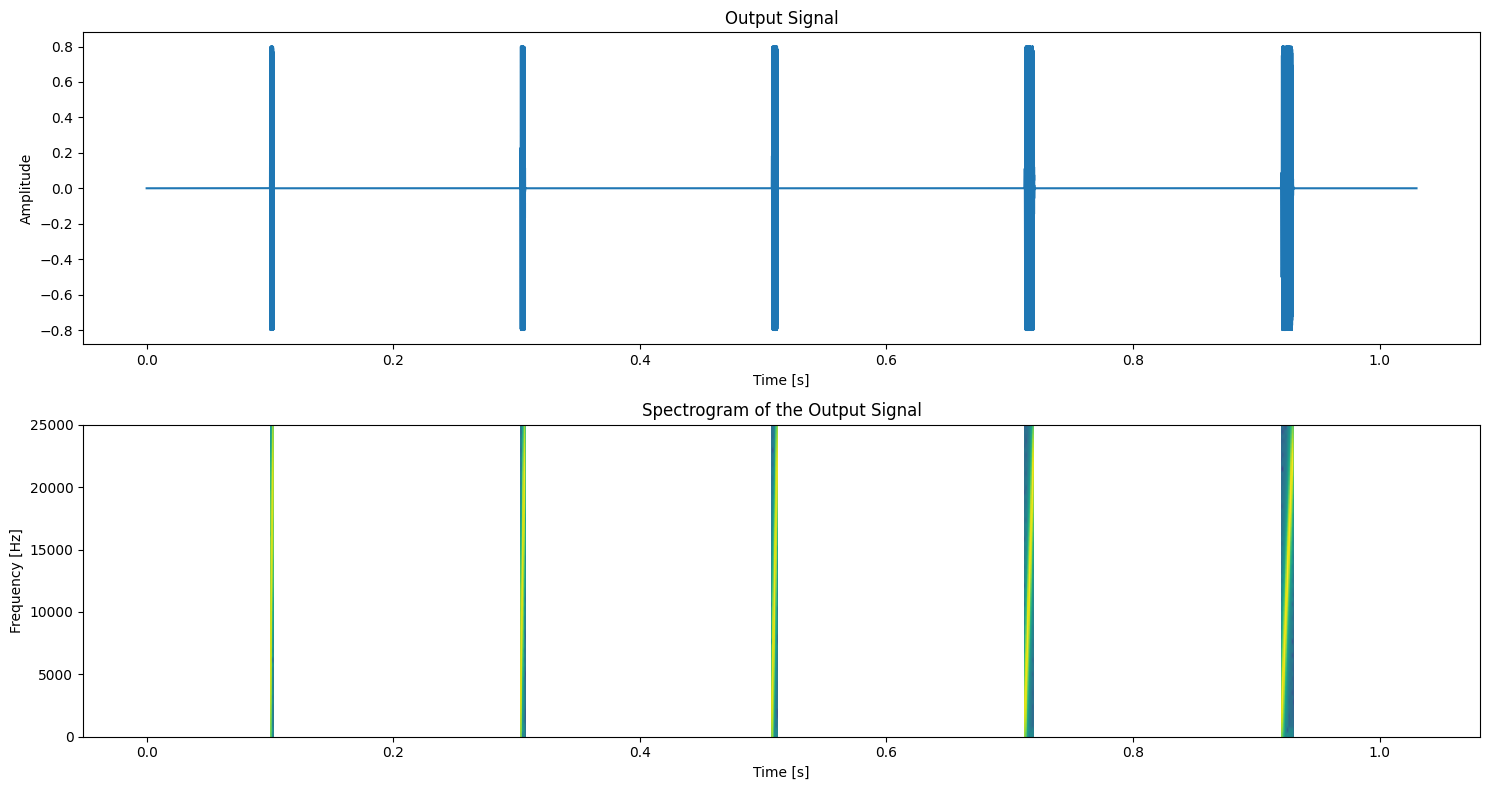

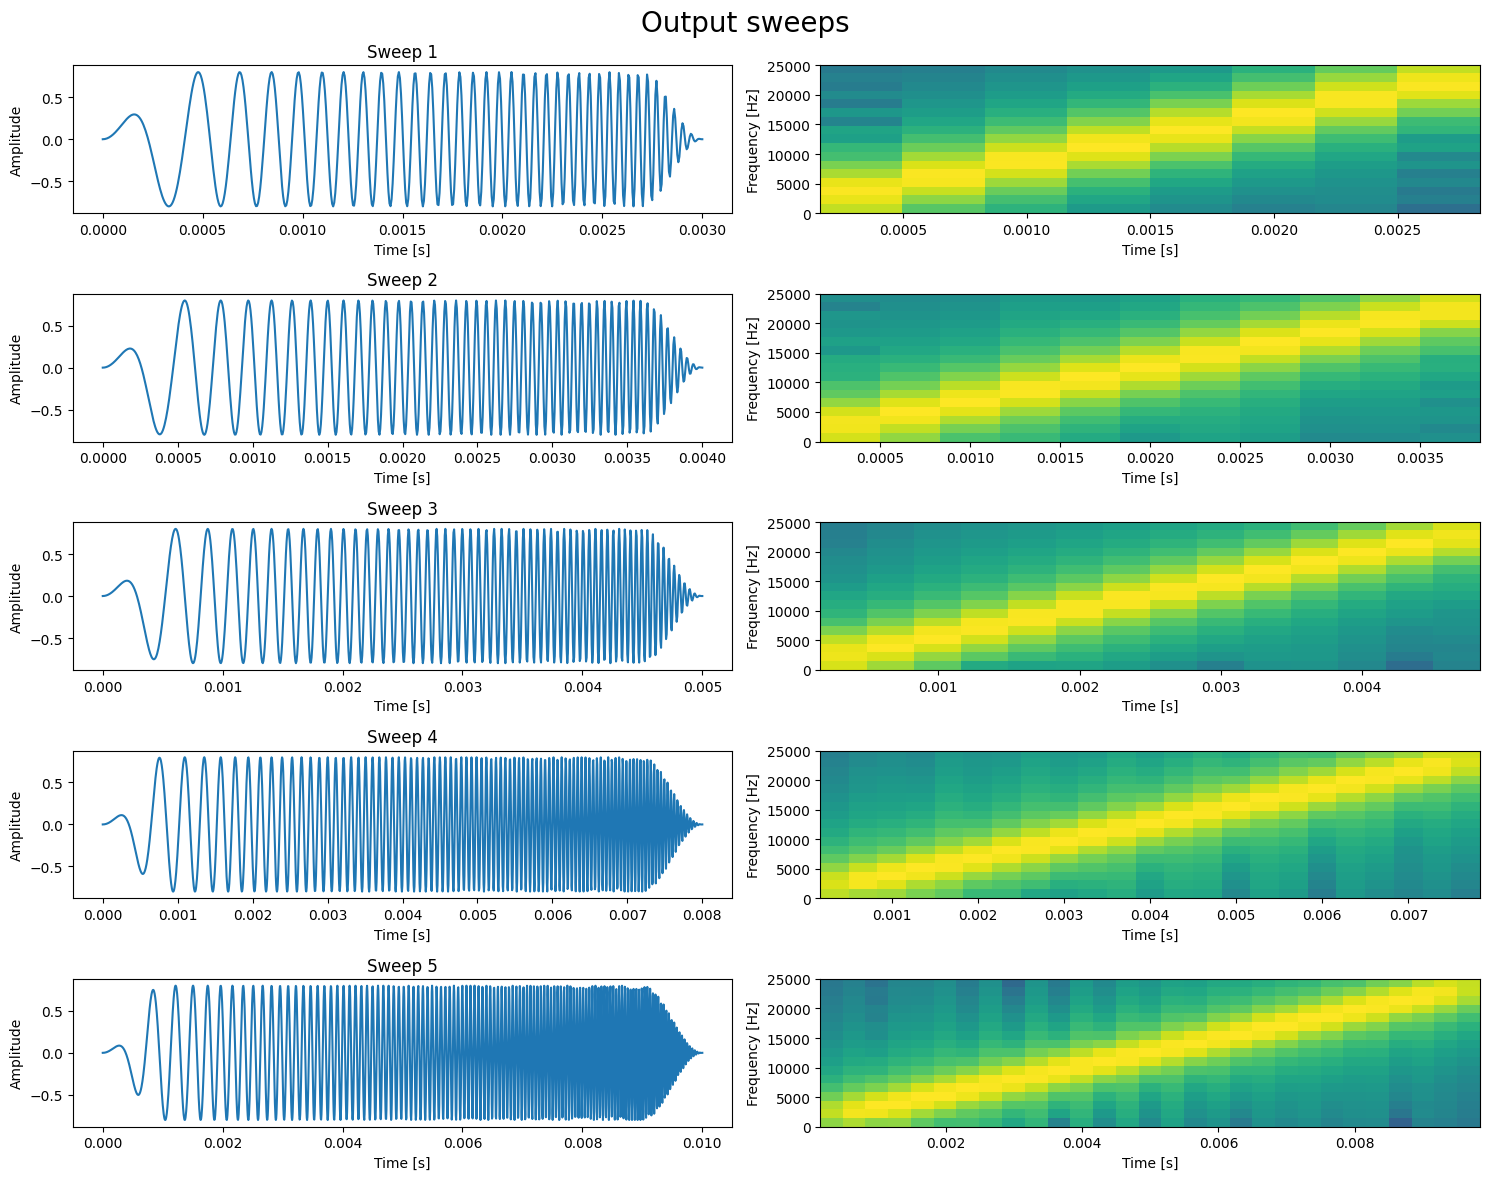

In [3]:
durns = np.array([3, 4, 5, 8, 10] )*1e-3

amps_1 = [0.1, 0.5, 1, 2] # Amplitudes for the first file
amps_2 = [0.1, 0.3, 0.5, 0.7, 1] # Amplitudes for the second file

fs = 192000 # Hz

chirp = []
all_sweeps = []
for durn in durns:
    t = np.linspace(0, durn, int(fs*durn))
    start_f, end_f = 2e2, 24e3
    sweep = signal.chirp(t, start_f, t[-1], end_f)
    sweep *= signal.windows.tukey(sweep.size, 0.2)
    sweep *= 0.8
    sweep_padded = np.pad(sweep, pad_width=[int(fs*0.1)]*2, constant_values=[0,0])
    all_sweeps.append(sweep_padded)
    chirp.append(sweep)

# Read the saved WAV file
out_signal, _ = sf.read('./2025-06-11/02_24k_5sweeps.wav')

# Plot the time-domain signal and spectrogram
plt.figure(figsize=(15, 8))

# Time-domain plot
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, len(out_signal) / fs, len(out_signal)), out_signal)
plt.title('Output Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Spectrogram plot
plt.subplot(2, 1, 2, sharex=plt.gca())
plt.specgram(out_signal, Fs=fs, NFFT=512, noverlap=256, cmap='viridis')
plt.title('Spectrogram of the Output Signal')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 25e3)
plt.tight_layout()

plt.figure(figsize=(15, 12))
for i, sweep in enumerate(chirp):
    plt.subplot(len(chirp), 2, 2 * i + 1)
    plt.plot(np.linspace(0, len(sweep) / fs, len(sweep)), sweep)
    plt.title(f'Sweep {i+1}')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    # Spectrogram plot

    plt.subplot(len(chirp), 2, 2 * i + 2)
    plt.specgram(sweep, Fs=fs, NFFT=128, noverlap=64, cmap='viridis')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.ylim(0, 25e3)
    plt.suptitle('Output sweeps', fontsize=20)

plt.tight_layout()
plt.show()

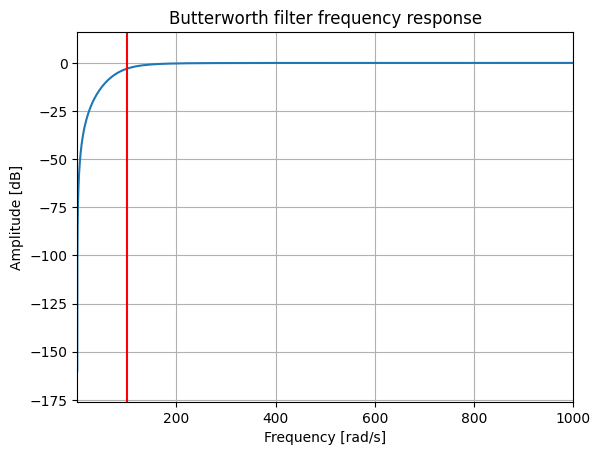

Detected peaks: gras = 5


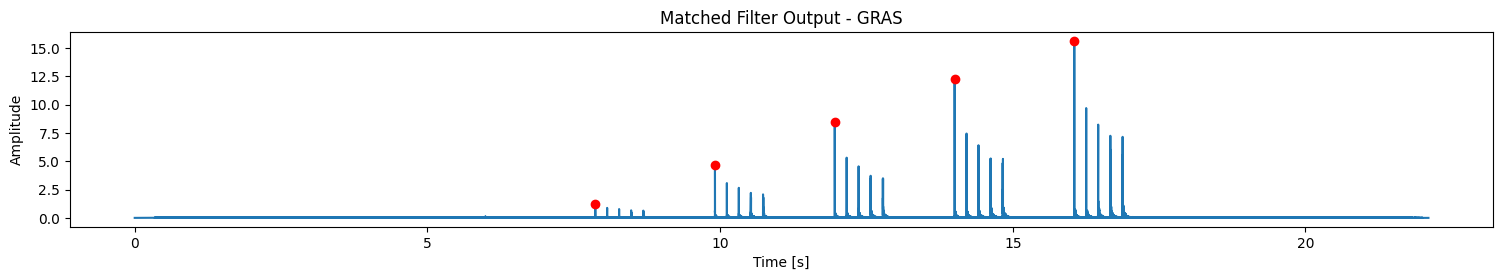

In [4]:
# Define the matched filter function
def matched_filter(recording, chirp_template):
    filtered_output = np.roll(signal.correlate(recording, chirp_template, 'same', method='direct'), -len(chirp_template)//2)
    filtered_output *= signal.windows.tukey(filtered_output.size, 0.1)
    filtered_envelope = np.abs(signal.hilbert(filtered_output))
    return filtered_envelope

# Detect peaks in the matched filter output
def detect_peaks(filtered_output, sample_rate):
    peaks, properties = signal.find_peaks(filtered_output, prominence=0.2, distance=2 * sample_rate)
    return peaks

# Design the highpass filter
cutoff = 100 # cutoff frequency in Hz
# Plot the filter frequency response
b, a = signal.butter(2, cutoff, 'high', analog=True)
w, h = signal.freqs(b, a)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='red') # cutoff frequency
plt.show()

# load the GRAS audio files
gras_pbk_audio_or, fs = sf.read('./2025-06-11/in9_192khz_chA_+40db_1m_take2.wav')

chirp_to_use = 0

# Apply the filter
sos = signal.butter(2, cutoff, 'hp', fs=fs, output='sos')
gras_pbk_audio_filt = sig.sosfilt(sos, gras_pbk_audio_or)

gras_pbk_audio_matched = matched_filter(gras_pbk_audio_filt, chirp[chirp_to_use])

# Detect peaks
peaks_gras = detect_peaks(gras_pbk_audio_matched, fs)
print(f"Detected peaks: gras = {len(peaks_gras)}")

# plot the peaks
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, len(gras_pbk_audio_matched) / fs, len(gras_pbk_audio_matched)), gras_pbk_audio_matched)
plt.plot(peaks_gras/fs, gras_pbk_audio_matched[peaks_gras], 'ro')
plt.title('Matched Filter Output - GRAS')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

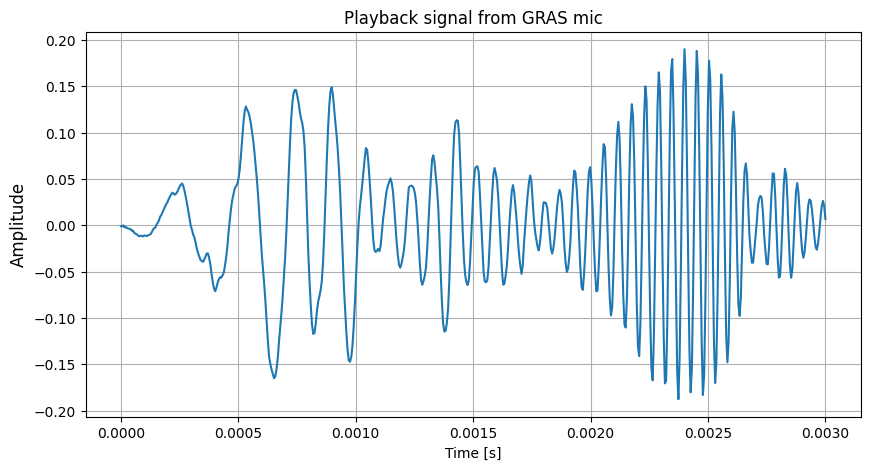

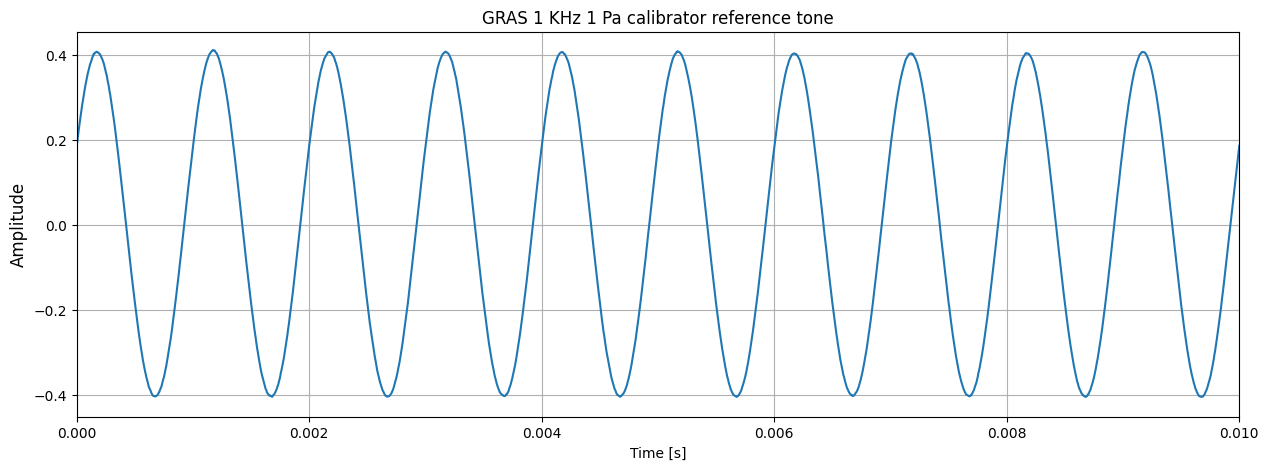

In [5]:

amplitude = 1 # Amplitude of the chirp to use referred to the amps_1 array

# Get the index of the amplitude variable inside amps_1 array
amplitude_index = amps_2.index(amplitude)

gras_pbk_audio = gras_pbk_audio_filt[int(peaks_gras[amplitude_index]):int(peaks_gras[amplitude_index]) + int(fs*durns[chirp_to_use])]

# Plot the playback signals
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(gras_pbk_audio)/fs, len(gras_pbk_audio)) ,gras_pbk_audio)
plt.title('Playback signal from GRAS mic')
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude', fontsize=12)

# Load the 1 Pa reference tone 
gras_1Pa_tone, fs_gras = sf.read('./2025-06-11/in9_192khz_chA_+40db_1Pa_reftone.wav', start=int(fs*0.5),
                        stop=int(fs*1.5))
gras_1Pa_tone = sig.resample(gras_1Pa_tone, fs*1)

# Plot the reference tone
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,len(gras_1Pa_tone)/fs, len(gras_1Pa_tone)), gras_1Pa_tone)
plt.title('GRAS 1 KHz 1 Pa calibrator reference tone')
plt.xlim(0, 0.01)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude', fontsize=12)
plt.grid()

/home/alberto/miniconda3/envs/robat2/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alberto/miniconda3/envs/robat2/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


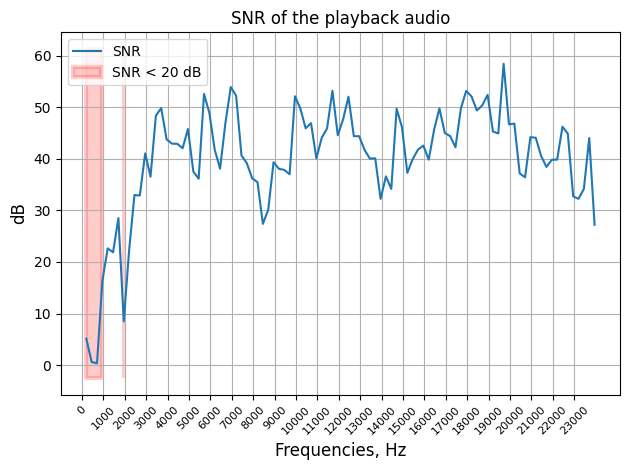

In [6]:
# SNR computation between the sweeps and the noise floor measurements for each freq band 

central_freq = np.arange(start_f, end_f, 250) 
BW = 0.25e3 # Bandwidth of each band

def calculate_snr(audio, noise):

    # Compute signal power (RMS value squared)
    P_signal = np.mean(audio**2)

    # extract noise power
    P_noise = np.mean(noise**2)

    # Compute SNR in dB
    SNR = P_signal / P_noise

    SNR_dB = 10 * np.log10(SNR)  # Convert to dB scale

    return SNR, SNR_dB

noises = []
Noise_ffts = []
for dur in durns:
    noise = gras_pbk_audio_filt[int(1*fs):int(1*fs) + int(fs*dur)]
    Noise_fft = np.fft.rfft(noise)
    Noise_fftfreqs = np.fft.rfftfreq(noise.size, 1/fs)
    noises.append(noise)
    Noise_ffts.append(Noise_fft)

# Signal fft of playback audio
gras_pbk_audio_fft = np.fft.rfft(gras_pbk_audio) # Compute the FFT of the noise files
gras_pbk_audio_fftfreqs = np.fft.rfftfreq(gras_pbk_audio.size, 1/fs)

all_snrs = {}
for i in range(len(noises)):
    Noise_fft = Noise_ffts[i]
    Noise_fftfreqs = np.fft.rfftfreq(noises[i].size, 1/fs)
    snrs = []
    for fc in central_freq:
        snr_value, snr_value_db = calculate_snr(
                                gras_pbk_audio_fft[(gras_pbk_audio_fftfreqs < fc + BW) & (gras_pbk_audio_fftfreqs > fc - BW)],    
                                Noise_fft[(Noise_fftfreqs < fc + BW) & (Noise_fftfreqs > fc - BW)]) # Compute the SNR in the band
        snrs.append(snr_value)
    snrs = np.array(snrs)
    # Store SNRs for each noise segment in a list or array indexed by i
    all_snrs[i] = snrs

SNR = all_snrs[chirp_to_use]

# Plot the SNR
plt.figure()
plt.plot(central_freq, 10 * np.log10(SNR), label='SNR')
# Mark with red zone the frequencies with SNR lower than 20 dB
snr_db = 10 * np.log10(SNR)
low_snr_mask = snr_db < 20
if np.any(low_snr_mask):
    plt.fill_between(central_freq, plt.ylim()[0], plt.ylim()[1], where=low_snr_mask, color='red', alpha=0.2, label='SNR < 20 dB', linewidth=3)

plt.xlabel('Frequencies, Hz', fontsize=12);
plt.ylabel('dB', fontsize=12)
plt.grid()
plt.xticks(np.arange(0, end_f, 1000), rotation=45, fontsize=8)
plt.title('SNR of the playback audio')
plt.legend()
plt.tight_layout()
plt.show()

The calibration mic has a sensitivity of 0.286rms/Pa. RMS relevant only for this ADC!

Infos about the frequencies considered in the analysis:
Index for starting freq = 200.0 Hz: 1, correspondent frequency band: 333.3333333333333 Hz
Index for ending freq = 24000.0 Hz: 72, correspondent frequency band: 24000.0 Hz


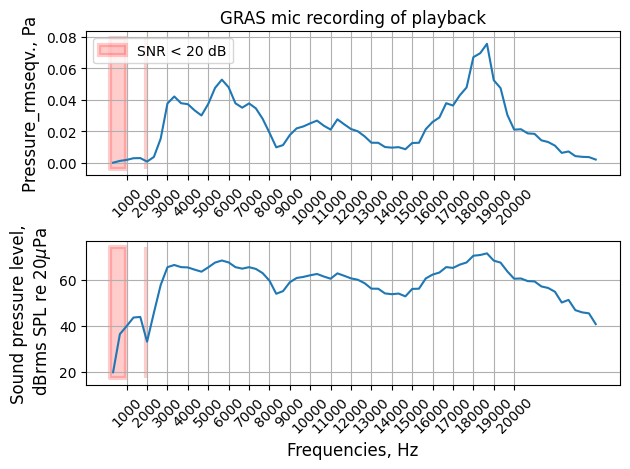

In [7]:
# Calibration mic: Calculate the rms_Pascal of the 1 Pa calibration tone
rms_1Pa_tone = rms(gras_1Pa_tone)
print(f'The calibration mic has a sensitivity of {np.round(rms_1Pa_tone,3)}rms/Pa. RMS relevant only for this ADC!')

# Now measure mic RMS over all frequency bands
gras_centrefreqs, gras_freqrms = calc_native_freqwise_rms(gras_pbk_audio, fs)

# Filter out the frequencies that are not in the original signal 
mask = (gras_centrefreqs >= start_f) & (gras_centrefreqs <= end_f)

idx_start = np.where(gras_centrefreqs >= start_f)[0][0]
idx_end = np.where(gras_centrefreqs <= end_f)[0][-1]
print("\nInfos about the frequencies considered in the analysis:")
print(f"Index for starting freq = {start_f} Hz: {idx_start}, correspondent frequency band: {gras_centrefreqs[idx_start]} Hz")
print(f"Index for ending freq = {end_f} Hz: {idx_end}, correspondent frequency band: {gras_centrefreqs[idx_end]} Hz")

gras_centrefreqs = gras_centrefreqs[mask]

gras_freqrms = gras_freqrms[idx_start:idx_end+1]

# Convert from RMS to Pascals (rms equivalent) since we know the GRAS sensitivity
gras_freqParms = gras_freqrms/rms_1Pa_tone # now the levels of each freq band in Pa_rms

plt.figure()
a0 = plt.subplot(211)
plt.plot(gras_centrefreqs, gras_freqParms)
snr_db = 10 * np.log10(SNR)
low_snr_mask = snr_db < 20
if np.any(low_snr_mask):
    plt.fill_between(central_freq, plt.ylim()[0], plt.ylim()[1], where=low_snr_mask, color='red', alpha=0.2, label='SNR < 20 dB', linewidth=3)
plt.ylabel('a.u. RMS/Pa', fontsize=12)
plt.ylabel('Pressure_rmseqv., Pa', fontsize=12)
plt.title('GRAS mic recording of playback')
plt.grid()
plt.legend()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.subplot(212, sharex=a0)
plt.plot(gras_centrefreqs, pascal_to_dbspl(gras_freqParms))
snr_db = 10 * np.log10(SNR)
low_snr_mask = snr_db < 20
if np.any(low_snr_mask):
    plt.fill_between(central_freq, plt.ylim()[0], plt.ylim()[1], where=low_snr_mask, color='red', alpha=0.2, label='SNR < 20 dB', linewidth=3)
plt.ylabel('a.u. RMS/Pa', fontsize=12)
plt.xlabel('Frequencies, Hz', fontsize=12);
plt.ylabel('Sound pressure level,\n dBrms SPL re 20$\mu$Pa', fontsize=12)
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.tight_layout()


Infos about the frequencies considered in the analysis:
Index for starting freq = 200.0 Hz: 1, correspondent frequency band: 333.3333333333333 Hz
Index for ending freq = 24000.0 Hz: 72, correspondent frequency band: 24000.0 Hz


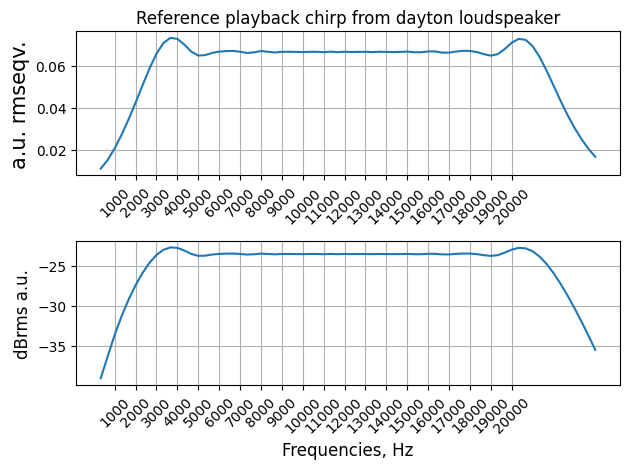

In [8]:

# Reference input signal (chirp)
ref_pbk_audio = chirp[chirp_to_use]
val_pbk_audio = chirp[chirp_to_use+1]

# Now measure chirp RMS over all frequency bands
ref_pbk_centrefreqs, ref_pbk_freqrms = calc_native_freqwise_rms(ref_pbk_audio, fs)

mask = (ref_pbk_centrefreqs >= start_f) & (ref_pbk_centrefreqs <= end_f)

idx_start = np.where(ref_pbk_centrefreqs >= start_f)[0][0]
idx_end = np.where(ref_pbk_centrefreqs <= end_f)[0][-1]
print("\nInfos about the frequencies considered in the analysis:")
print(f"Index for starting freq = {start_f} Hz: {idx_start}, correspondent frequency band: {ref_pbk_centrefreqs[idx_start]} Hz")
print(f"Index for ending freq = {end_f} Hz: {idx_end}, correspondent frequency band: {ref_pbk_centrefreqs[idx_end]} Hz")

ref_pbk_centrefreqs = ref_pbk_centrefreqs[mask]
    
ref_pbk_freqrms = ref_pbk_freqrms[idx_start:idx_end+1]

plt.figure()
a0 = plt.subplot(211)
plt.plot(ref_pbk_centrefreqs, ref_pbk_freqrms)
plt.ylabel('a.u. rmseqv.', fontsize=15)
plt.title('Reference playback chirp from dayton loudspeaker')
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.subplot(212, sharex=a0)
plt.plot(ref_pbk_centrefreqs, dB(ref_pbk_freqrms))
plt.xlabel('Frequencies, Hz', fontsize=12);
plt.ylabel('dBrms a.u.', fontsize=12)
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.tight_layout()


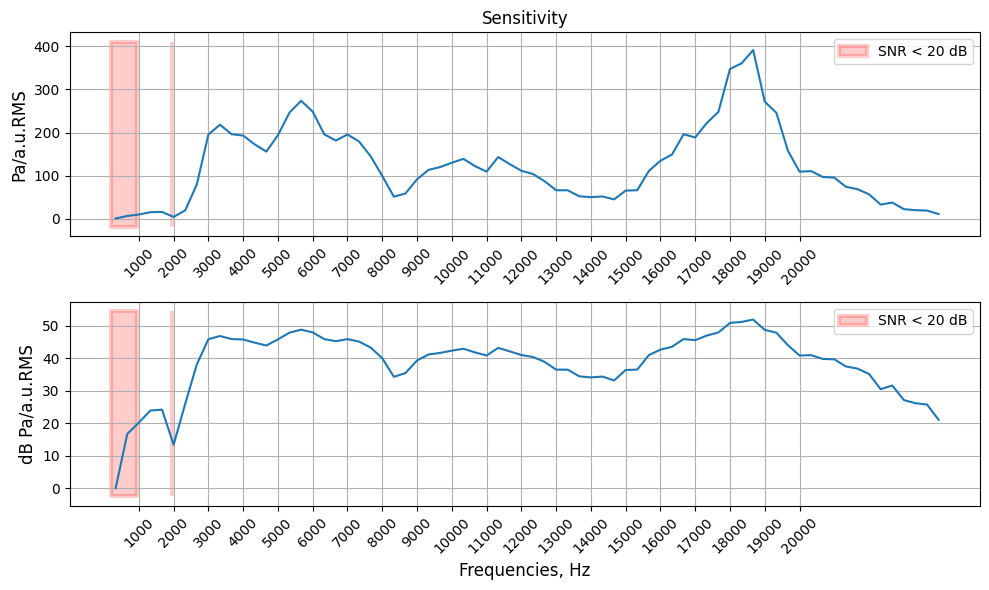

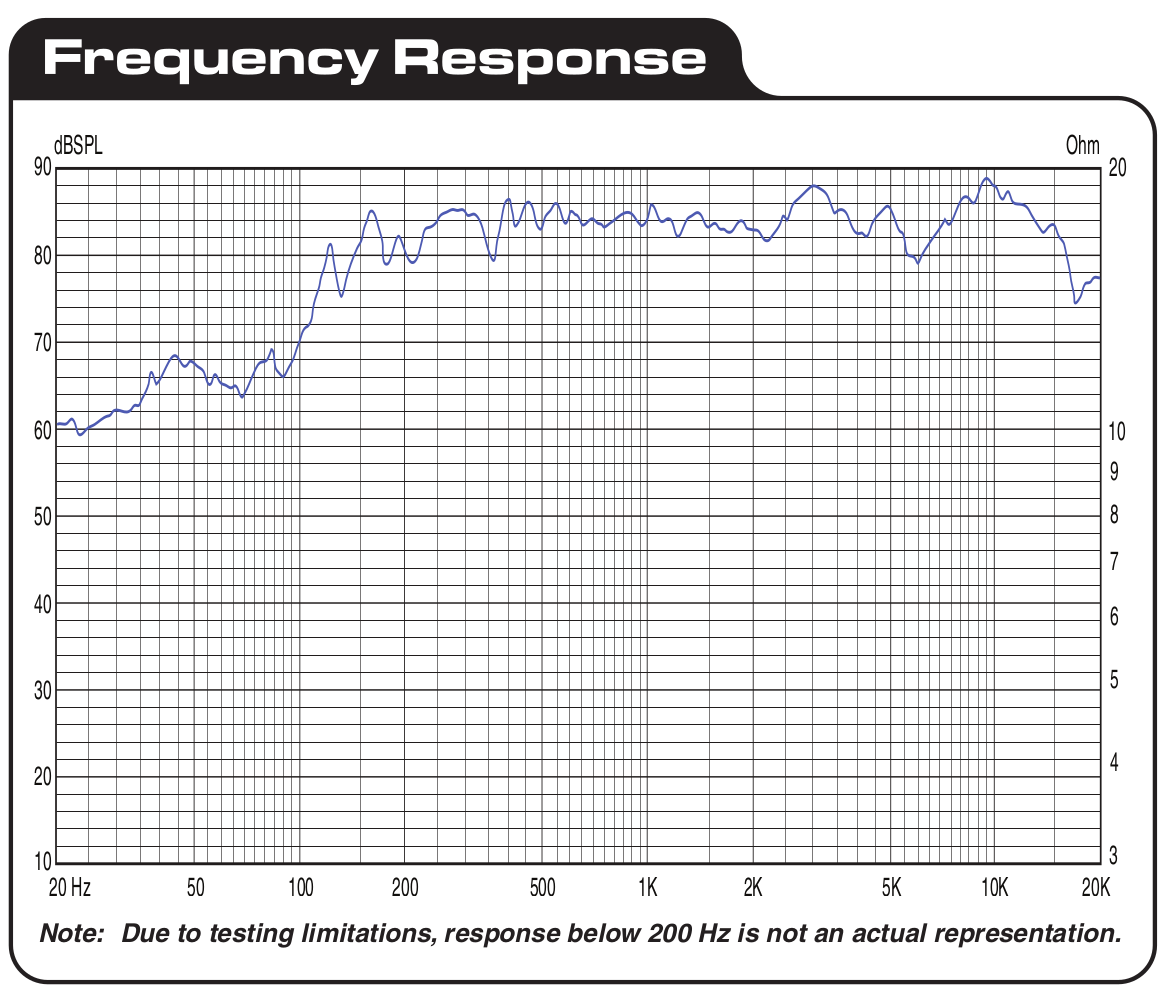

In [9]:
# Now let's calculate the Pa/RMS sensitivity of the loudspeaker

ref_pbk_freqrms_int = interpolate_freq_response([gras_centrefreqs, gras_freqParms],
                          ref_pbk_freqrms)

loudsp_sensitivity = np.array(gras_freqParms)/np.array(ref_pbk_freqrms_int) # Pa/RMS 
# loudsp_sensitivity = np.array(ref_pbk_freqrms_int)/np.array(gras_freqParms) # RMS/Pa
# # Print and plot the sensitivity at 1000 Hz
# target_freq = 1000  # Hz
# # Find the index closest to 1000 Hz
# idx_1000 = np.argmin(np.abs(SPH0645_centrefreqs - target_freq))
# print(f'The target mic has a sensitivity at {SPH0645_centrefreqs[idx_1000]} Hz of: {dB(SPH0645_sensitivity[idx_1000])} dB a.u. rms/Pa')
# 
plt.figure(figsize=(10, 6))
a0 = plt.subplot(211)
plt.plot(ref_pbk_centrefreqs, loudsp_sensitivity)
snr_db = 10 * np.log10(SNR)
low_snr_mask = snr_db < 20
if np.any(low_snr_mask):
    plt.fill_between(central_freq, plt.ylim()[0], plt.ylim()[1], where=low_snr_mask, color='red', alpha=0.2, label='SNR < 20 dB', linewidth=3)
plt.ylabel('Pa/a.u.RMS', fontsize=12)
plt.title('Sensitivity')
plt.grid()
plt.legend()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.subplot(212, sharex=a0)
plt.plot(ref_pbk_centrefreqs, dB(loudsp_sensitivity))
if np.any(low_snr_mask):
    plt.fill_between(central_freq, plt.ylim()[0], plt.ylim()[1], where=low_snr_mask, color='red', alpha=0.2, label='SNR < 20 dB', linewidth=3)
plt.xlabel('Frequencies, Hz', fontsize=12);
plt.ylabel('dB Pa/a.u.RMS', fontsize=12)
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

display(
    Image(filename="./dayton_audio_CE32A-4_freq_response.png", width=900),
)


Infos about the frequencies considered in the analysis for the SPH0645LM4H-B:
Index for starting freq = 200.0 Hz: 1, correspondent frequency band: 250.0 Hz
Index for ending freq = 24000.0 Hz: 96, correspondent frequency band: 24000.0 Hz


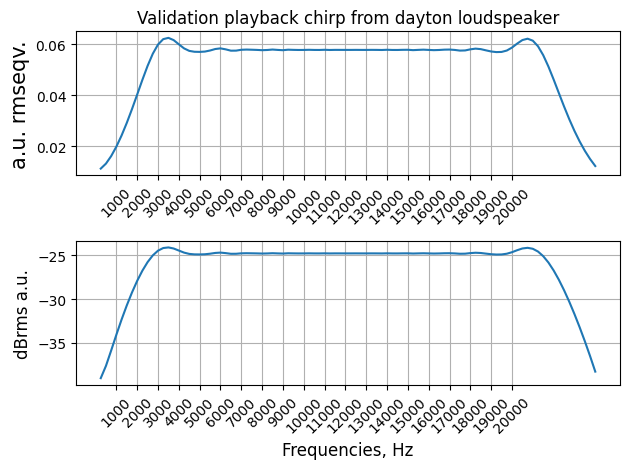

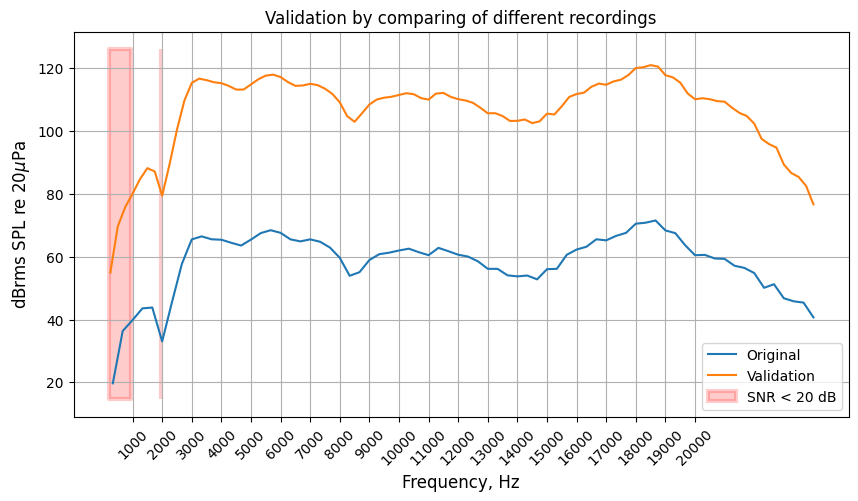

In [10]:
# And finally let's check that the calibration makes sense
# using a sound that we didn't use to calculate the sensitivity
# If the length of the recorded target mic audio here is not the same as the calibration audio. 
# then you'll need to interpolate the sensitivity using interpolate_freq_response in the
# utilities.py module

#recsound_centrefreqs, freqwise_rms = calc_native_freqwise_rms(gras_valid_rec, fs)
recsound_centrefreqs, freqwise_rms = calc_native_freqwise_rms(val_pbk_audio,fs)

mask = (recsound_centrefreqs >= start_f) & (recsound_centrefreqs <= end_f)
idx_start = np.where(recsound_centrefreqs >= start_f)[0][0]
idx_end = np.where(recsound_centrefreqs <= end_f)[0][-1]
print("\nInfos about the frequencies considered in the analysis for the SPH0645LM4H-B:")
print(f"Index for starting freq = {start_f} Hz: {idx_start}, correspondent frequency band: {recsound_centrefreqs[idx_start]} Hz")
print(f"Index for ending freq = {end_f} Hz: {idx_end}, correspondent frequency band: {recsound_centrefreqs[idx_end]} Hz")

recsound_centrefreqs = recsound_centrefreqs[mask]
freqwise_rms = freqwise_rms[idx_start:idx_end+1]

plt.figure()
a0 = plt.subplot(211)
plt.plot(recsound_centrefreqs, freqwise_rms)
plt.ylabel('a.u. rmseqv.', fontsize=15)
plt.title('Validation playback chirp from dayton loudspeaker')
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.subplot(212, sharex=a0)
plt.plot(recsound_centrefreqs, dB(freqwise_rms))
plt.xlabel('Frequencies, Hz', fontsize=12);
plt.ylabel('dBrms a.u.', fontsize=12)
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.tight_layout()

interp_sensitivity = interpolate_freq_response([ref_pbk_centrefreqs, loudsp_sensitivity],
                          recsound_centrefreqs)

freqwise_Parms = freqwise_rms*interp_sensitivity

plt.figure(figsize=(10, 5))
plt.plot(gras_centrefreqs, pascal_to_dbspl(gras_freqParms), label='Original')
plt.plot(recsound_centrefreqs, pascal_to_dbspl(freqwise_Parms), label='Validation')
# plt.plot(central_freq, 10 * np.log10(SNR), label='SNR original')
# Mark with red zone the frequencies with SNR lower than 20 dB
snr_db = 10 * np.log10(SNR)
low_snr_mask = snr_db < 20
if np.any(low_snr_mask):
    plt.fill_between(central_freq, plt.ylim()[0], plt.ylim()[1], where=low_snr_mask, color='red', alpha=0.2, label='SNR < 20 dB', linewidth=3)
plt.xlabel('Frequency, Hz', fontsize=12)
plt.title('Validation by comparing of different recordings')
plt.ylabel('dBrms SPL re 20$\mu$Pa', fontsize=12)
plt.legend()
plt.grid()
plt.xticks(np.linspace(1000, 20000, 20), rotation=45)
plt.show()

In [11]:
# Now we know the sensitivity of the target mic - let's finally calculate
# the dB SPL of the recorded sound!
# We rely on combining the Pa rms of all relevant frequencies 
# e.g. see https://electronics.stackexchange.com/questions/642109/summing-rms-values-proof

frequency_band = [0.2e3, 24e3] # min, max frequency to do the compensation Hz

tgtmic_relevant_freqs = np.logical_and(gras_centrefreqs>=frequency_band[0],
                                gras_centrefreqs<=frequency_band[1])
total_rms_freqwise_Parms = np.sqrt(np.sum(gras_freqParms[tgtmic_relevant_freqs]**2))

valid_tgtmic_relevant_freqs = np.logical_and(recsound_centrefreqs>=frequency_band[0],
                                recsound_centrefreqs<=frequency_band[1])
valid_total_rms_freqwise_Parms = np.sqrt(np.sum(freqwise_Parms[valid_tgtmic_relevant_freqs]**2))


print(f'GRAS dBrms SPL measure: {pascal_to_dbspl(total_rms_freqwise_Parms)}')
print(f'GRAS dBrms SPL measure: {pascal_to_dbspl(valid_total_rms_freqwise_Parms)}')

GRAS dBrms SPL measure: [81.97635385]
GRAS dBrms SPL measure: [132.78644613]
